In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

## Loading dataset

In [3]:
from saltsegm.dataset import Dataset

In [4]:
train_path = '/cobrain/groups/ml_group/data/dustpelt/salt_prep/train/'
test_path = '/cobrain/groups/ml_group/data/dustpelt/salt_prep/test/'

In [5]:
ds_train = Dataset(train_path)
ds_test = Dataset(test_path)

In [6]:
ds_train.metadata.head()

,id,image,target,image-128,target-128,z,target_ratio,is_not_empty
0,575d24d81d,575d24d81d/image.npy,575d24d81d/target.npy,575d24d81d/image128.npy,575d24d81d/target128.npy,843,0.000000,True
1,a266a2a9df,a266a2a9df/image.npy,a266a2a9df/target.npy,a266a2a9df/image128.npy,a266a2a9df/target128.npy,794,0.504950,True
2,75efad62c1,75efad62c1/image.npy,75efad62c1/target.npy,75efad62c1/image128.npy,75efad62c1/target128.npy,468,0.993334,True
3,34e51dba6a,34e51dba6a/image.npy,34e51dba6a/target.npy,34e51dba6a/image128.npy,34e51dba6a/target128.npy,727,0.149201,True
4,4875705fb0,4875705fb0/image.npy,4875705fb0/target.npy,4875705fb0/image128.npy,4875705fb0/target128.npy,797,0.042839,True


## Take a look at the random images

In [7]:
ids_to_show = [5,6,7,8]

xs, ys, zs = [], [], []
for _id in ids_to_show:
    xs.append(ds_train.load_x(_id)[0])
    ys.append(ds_train.load_y(_id)[0])
    zs.append(ds_train.metadata.iloc[_id]['z'])

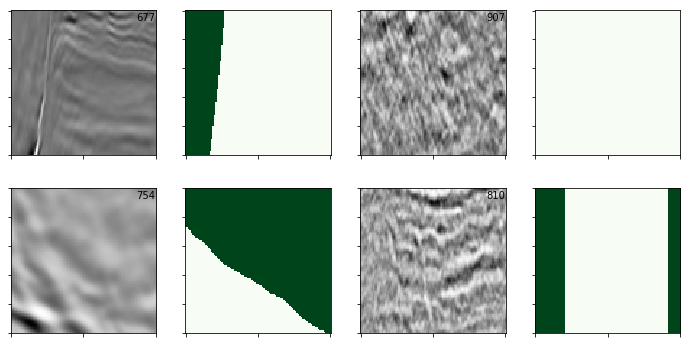

In [8]:
cols = 4
rows = 2

fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))

for i, (x, y, z) in enumerate(zip(xs, ys, zs)):
    ax_x = axs[int(2 * i / cols), 2 * i % cols]
    ax_y = axs[int(2 * i / cols), 2 * i % cols + 1]
    
    ax_x.imshow(x, cmap='Greys')
    ax_x.text(x.shape[0] - 1, 1, round(z, 2), color="black", ha="right", va="top")
    ax_y.imshow(y, cmap='Greens')
    
    ax_x.set_yticklabels([])
    ax_x.set_xticklabels([])
    ax_y.set_yticklabels([])
    ax_y.set_xticklabels([])
    
plt.show()

## Some general statistics

### Train

In [9]:
n_imgs = ds_train.metadata.shape[0]
print('Total number of images: {}'.format(n_imgs))
print('\n')

n_empty_masks = len(
    ds_train.metadata['target_ratio'].values[ ds_train.metadata['target_ratio'].values == 0 ]
)
print('Ratio of empty masks is {}'.format(n_empty_masks / n_imgs))
print('Empty masks: {}'.format(n_empty_masks))
print('\n')

n_empty_imgs = np.sum( ~(ds_train.metadata['is_not_empty'].values) )
print('Ratio of empty images is {}'.format(n_empty_imgs / n_imgs))
print('Empty images: {}'.format(n_empty_imgs))

Total number of images: 4000


Ratio of empty masks is 0.3905
Empty masks: 1562


Ratio of empty images is 0.02
Empty images: 80


### Test

In [10]:
n_imgs = ds_test.metadata.shape[0]
print('Total number of images: {}'.format(n_imgs))
print('\n')

n_empty_imgs = np.sum( ~(ds_test.metadata['is_not_empty'].values) )
print('Ratio of empty images is {}'.format(n_empty_imgs / n_imgs))
print('Empty images: {}'.format(n_empty_imgs))

Total number of images: 18000


Ratio of empty images is 0.02388888888888889
Empty images: 430


## Target ratio distribution

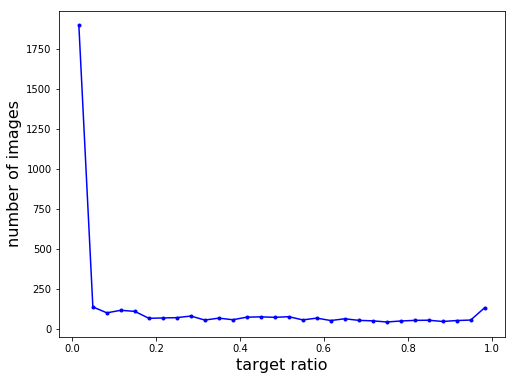

In [11]:
n_values, x_edges = np.histogram( ds_train.metadata['target_ratio'].values, bins=30 )

x_values = []
for i in range(len(x_edges) - 1):
    x_values.append( (x_edges[i] + x_edges[i+1]) / 2 )

plt.figure(figsize=(8,6))

plt.plot(x_values, n_values, 'b-')
plt.plot(x_values, n_values, 'b.')

plt.xlabel('target ratio', fontsize=16)
plt.ylabel('number of images', fontsize=16)

plt.show()

## Intensity sum distribution

In [12]:
train_intens_sums = []
intens_sums_nonempty = []

for _id in tqdm(ds_train.ids):
    x = ds_train.load_x(_id)[0]
    y = ds_train.load_y(_id)[0]

    train_intens_sums.append(np.sum(x))

    if np.sum(y) > 0:
        intens_sums_nonempty.append(np.sum(x))

train_intens_sums = np.array(train_intens_sums)
min_intens = np.min(intens_sums_nonempty)
max_intens = np.max(intens_sums_nonempty)

100%|██████████| 4000/4000 [00:20<00:00, 195.89it/s]


In [13]:
test_intens_sums = []

for _id in tqdm(ds_test.ids):
    x = ds_test.load_x(_id)[0]
    test_intens_sums.append(np.sum(x))
    
test_intens_sums = np.array(test_intens_sums)

100%|██████████| 18000/18000 [01:00<00:00, 299.76it/s]


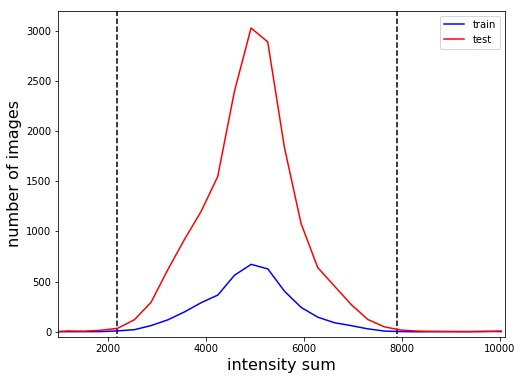

In [14]:
train_n_values, train_x_edges = np.histogram( train_intens_sums, bins=30 )
test_n_values, test_x_edges = np.histogram( test_intens_sums, bins=30 )

train_x_values = []
for i in range(len(train_x_edges) - 1):
    train_x_values.append( (train_x_edges[i] + train_x_edges[i+1]) / 2 )
    
test_x_values = []
for i in range(len(test_x_edges) - 1):
    test_x_values.append( (test_x_edges[i] + test_x_edges[i+1]) / 2 )

plt.figure(figsize=(8,6))

plt.plot(train_x_values, train_n_values, 'b-', label='train')
plt.plot(test_x_values, test_n_values, 'r-', label='test')

plt.xlabel('intensity sum', fontsize=16)
plt.ylabel('number of images', fontsize=16)

plt.vlines(x=min_intens, ymin=-100, ymax=4000, color='k', linestyle='--')
plt.vlines(x=max_intens, ymin=-100, ymax=4000, color='k', linestyle='--')

plt.xlim((1000, 10100))
plt.ylim((-50, 3200))

plt.legend()

plt.show()

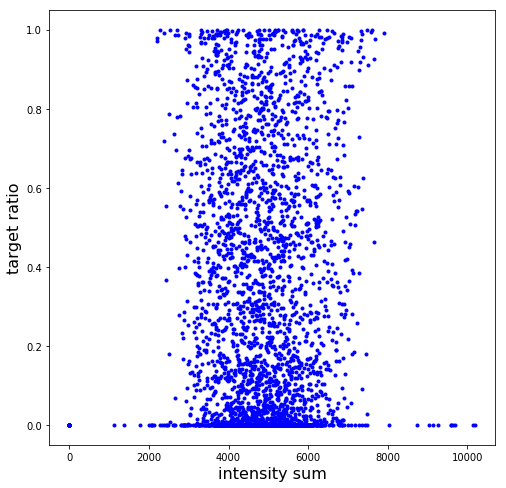

In [15]:
plt.figure(figsize=(8,8))

plt.plot(train_intens_sums, ds_train.metadata['target_ratio'].values, 'b.')

plt.xlabel('intensity sum', fontsize=16)
plt.ylabel('target ratio', fontsize=16)

plt.show()

## Depths distribution

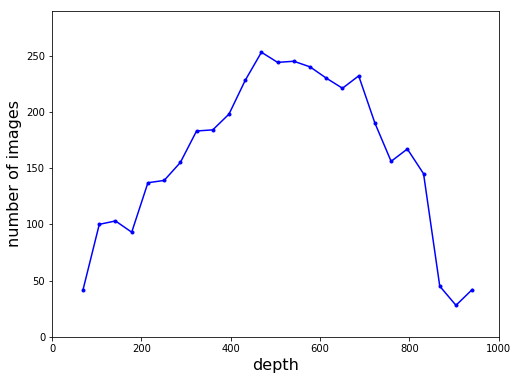

In [10]:
ratio_values, x_edges = np.histogram( ds_train.metadata['z'].values, bins=25 )

x_values = []
for i in range(len(x_edges) - 1):
    x_values.append( (x_edges[i] + x_edges[i+1]) / 2 )

plt.figure(figsize=(8,6))

plt.plot(x_values, ratio_values, 'b-')
plt.plot(x_values, ratio_values, 'b.')

plt.xlabel('depth', fontsize=16)
plt.ylabel('number of images', fontsize=16)

plt.xlim((0, 1000))
plt.ylim((0, 290))

plt.show()

## Depth

In [16]:
from ipywidgets import IntSlider, interact

In [17]:
metadata_sorted = ds_train.metadata.sort_values(by='z')
idx_sorted = metadata_sorted.index

In [18]:
x_sorted = []
y_sorted = []
for _id in tqdm(idx_sorted):
    x_sorted.append(ds_train.load_x(_id)[0])
    y_sorted.append(ds_train.load_y(_id)[0])

100%|██████████| 4000/4000 [00:19<00:00, 203.47it/s]


TODO: drop $<2000$ and $>8000$ images

In [19]:
def order2image(idx):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    ax_x = axs[0]
    ax_y = axs[1]
    
    ax_x.imshow(x_sorted[idx])
    ax_y.imshow(y_sorted[idx])
    
    plt.show()
    
    print('id: {}'.format(idx_sorted[idx]))

In [20]:
sld = IntSlider(min=0,max=len(idx_sorted)-1,step=1,continuous_update=False)

In [21]:
interact(order2image, idx=sld)

<function __main__.order2image>

# Summary

* no dependence of the "type" of salt from the depth!

* empty masks for images with $<2000$ and $>8000$ intensity sum

* firstly find all completely empty images, make empty masks for them and drop from research

* build classifier to find empty images with almost $100\%$ recall.